# Combined MERSCOPE ROI Differential Gene Expression Analysis

This script performs DGE analysis between corresponding ROIs from two different samples:
- Sample 1: p0, Region R4
- Sample 2: p30, Region R3

Comparisons:
- ROI1 (first identified ROI in Sample 1) vs. ROI1 (first identified ROI in Sample 2)
- ROI2 (second identified ROI in Sample 1) vs. ROI2 (second identified ROI in Sample 2)

In [1]:
# Import necessary libraries
import sys
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from shapely import wkt

project_root = "/beegfs/scratch/ric.sessa/kubacki.michal/SRF_Linda/SRF_Spatial_segmentation"
sys.path.append(project_root)
from HELPERs.plotting import create_volcano_plot

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning) # For sjoin warnings if CRS is not set

# Global plot settings
PLOT_INTERMEDIATE_ROI_VISUALIZATIONS = True # Set to True to see ROI plots during data loading
PLOT_FINAL_DGE_VOLCANO = True

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.se

## Helper Function: Load and Process Sample Data

In [2]:
class SampleProcessor:
    def __init__(self, base_path, h5ad_filename, cell_boundaries_filename, roi_csv_filename,
                 sample_prefix, target_roi_labels=['ROI1', 'ROI2'], min_gene_expression_per_cell=25,
                 use_raw_counts=False, raw_counts_csv_filename=None): # Added new params
        self.base_path = base_path
        self.h5ad_filename = h5ad_filename # Keep for potential fallback or metadata
        self.cell_boundaries_filename = cell_boundaries_filename
        self.roi_csv_filename = roi_csv_filename
        self.sample_prefix = sample_prefix
        self.target_roi_labels = target_roi_labels
        self.min_gene_expression_per_cell = min_gene_expression_per_cell
        self.use_raw_counts = use_raw_counts
        self.raw_counts_csv_filename = raw_counts_csv_filename

        self.h5ad_file_path = os.path.join(self.base_path, self.h5ad_filename) if self.h5ad_filename else None
        self.cell_boundaries_file_path = os.path.join(self.base_path, self.cell_boundaries_filename)
        self.roi_geometry_file_path = os.path.join(self.base_path, self.roi_csv_filename)
        self.raw_counts_csv_path = None
        if self.use_raw_counts and self.raw_counts_csv_filename:
            self.raw_counts_csv_path = os.path.join(self.base_path, self.raw_counts_csv_filename)
        elif self.use_raw_counts and not self.raw_counts_csv_filename:
            print(f"Warning for {self.sample_prefix}: 'use_raw_counts' is True, but 'raw_counts_csv_filename' is not provided. Will attempt to use H5AD.")
            self.use_raw_counts = False # Fallback to H5AD

        # Intermediate data products
        self.adata = None
        self.cell_boundaries_gdf = None
        self.roi_gdf = None
        self.cells_in_rois_gdf = None
        self.adata_filtered_rois = None # This will be the final result of run_all_steps

        # Configuration
        self.roi_group_column_in_csv = 'group' # As used in the original function

        print(f"\n--- Initializing SampleProcessor for sample: {self.sample_prefix} ---")

    def _load_h5ad(self): # Helper method
        print(f"Step 1: Loading H5AD AnnData for {self.sample_prefix} from {self.h5ad_file_path}")
        try:
            self.adata = sc.read_h5ad(self.h5ad_file_path)
            print(f"Initial adata shape from H5AD: {self.adata.shape}")
            if 'raw_data_loaded' not in self.adata.uns: # Avoid overwriting if already set by CSV attempt
                self.adata.uns['raw_data_loaded'] = False
        except Exception as e:
            print(f"Error loading H5AD for {self.sample_prefix}: {e}")
            self.adata = None

    def step_1_load_anndata(self):
        if self.use_raw_counts and self.raw_counts_csv_path and os.path.exists(self.raw_counts_csv_path):
            print(f"Step 1: Loading RAW AnnData for {self.sample_prefix} from {self.raw_counts_csv_path}")
            try:
                # Assuming CSV has cells as rows (index_col=0) and genes as columns
                raw_df = pd.read_csv(self.raw_counts_csv_path, index_col=0)
                self.adata = sc.AnnData(raw_df)
                # Ensure obs_names and var_names are strings for consistency
                self.adata.obs_names = raw_df.index.astype(str)
                self.adata.var_names = raw_df.columns.astype(str)
                print(f"Initial adata shape from CSV: {self.adata.shape}")
                self.adata.uns['raw_data_loaded'] = True
            except Exception as e:
                print(f"Error loading raw counts CSV for {self.sample_prefix}: {e}. Attempting to load H5AD if available.")
                if self.h5ad_file_path and os.path.exists(self.h5ad_file_path):
                    self._load_h5ad()
                else:
                    self.adata = None # No fallback possible
        elif self.h5ad_file_path and os.path.exists(self.h5ad_file_path):
            self._load_h5ad()
        else:
            print(f"Error in step_1_load_anndata for {self.sample_prefix}: No valid H5AD or raw CSV path provided/found.")
            self.adata = None
        return self.adata

    def step_2_filter_genes(self):
        if self.adata is None:
            print("Error in step_2_filter_genes: AnnData not loaded. Run step_1 first.")
            return None
        print(f"Step 2: Filtering 'Blank' genes for {self.sample_prefix}")
        genes_before_blank_filter = self.adata.shape[1]
        keep_genes = [x for x in self.adata.var.index.tolist() if 'Blank' not in x]
        self.adata = self.adata[:, keep_genes].copy()
        print(f"Filtered out 'Blank' genes. Kept {len(keep_genes)} out of {genes_before_blank_filter} genes. New shape: {self.adata.shape}")
        return self.adata

    def step_3_filter_cells(self):
        if self.adata is None:
            print("Error in step_3_filter_cells: AnnData not loaded/processed. Run previous steps.")
            return None
        print(f"Step 3: Filtering cells by min expression ({self.min_gene_expression_per_cell}) for {self.sample_prefix}")
        cells_before_min_expr_filter = self.adata.shape[0]
        ser_exp = self.adata.to_df().sum(axis=1)
        keep_cells = ser_exp[ser_exp >= self.min_gene_expression_per_cell].index.tolist()
        self.adata = self.adata[keep_cells, :].copy()
        print(f"Filtered cells by min expression. Kept {len(keep_cells)} out of {cells_before_min_expr_filter} cells. New shape: {self.adata.shape}")

        if self.adata.shape[0] == 0 or self.adata.shape[1] == 0:
            print(f"Warning: AnnData for {self.sample_prefix} is empty after initial filtering (step 3).")
            self.adata = None # Signal that processing cannot continue
        return self.adata

    def step_3_5_normalize_logtransform(self):
        if self.adata is None:
            print("Error in step_3_5_normalize_logtransform: AnnData is empty or not processed.")
            return None
        
        print(f"Step 3.5: Normalizing and log-transforming data for {self.sample_prefix}...")
        
        # Determine if normalization is needed:
        # - Always if loaded from raw CSV.
        # - If loaded from H5AD, only if not already log1p transformed.
        needs_normalization_and_log = self.adata.uns.get('raw_data_loaded', False) or \
                                      not self.adata.uns.get('log1p', False)

        if needs_normalization_and_log:
            if self.adata.uns.get('raw_data_loaded', False):
                print(f"Data for {self.sample_prefix} was loaded from raw counts. Applying sc.pp.normalize_total and sc.pp.log1p.")
            else: # From H5AD and not yet log-transformed
                print(f"Applying sc.pp.normalize_total (target_sum=1e4) and sc.pp.log1p for {self.sample_prefix} (H5AD, not pre-logged).")
            
            sc.pp.normalize_total(self.adata, target_sum=1e4)
            sc.pp.log1p(self.adata) # This will set adata.uns['log1p'] = {'base': None} or similar
            print("Per-sample normalization and log-transformation complete.")
        else:
            # This case means it's from H5AD and adata.uns['log1p'] was found.
            print(f"Data for {self.sample_prefix} (from H5AD) appears to be already log-transformed (adata.uns['log1p'] found). Skipping per-sample sc.pp.normalize_total and sc.pp.log1p.")
        return self.adata

    def step_4_load_cell_boundaries(self):
        print(f"Step 4: Loading cell boundaries for {self.sample_prefix} from {self.cell_boundaries_file_path}")
        self.cell_boundaries_gdf = gpd.read_parquet(self.cell_boundaries_file_path)
        # Ensure EntityID is string type before setting as index for consistency
        self.cell_boundaries_gdf['EntityID'] = self.cell_boundaries_gdf['EntityID'].astype(str)
        self.cell_boundaries_gdf = self.cell_boundaries_gdf.set_index('EntityID', drop=False)
        print(f"Loaded cell boundaries. Shape: {self.cell_boundaries_gdf.shape}")
        return self.cell_boundaries_gdf

    def step_5_load_roi_geometries(self):
        if self.cell_boundaries_gdf is None:
            print("Error in step_5_load_roi_geometries: Cell boundaries not loaded. Run step_4 first.")
            return None
        print(f"Step 5: Loading ROI geometry for {self.sample_prefix} from {self.roi_geometry_file_path}")
        roi_polygons_df = pd.read_csv(self.roi_geometry_file_path)
        roi_polygons_df['geometry'] = roi_polygons_df['geometry'].apply(wkt.loads)
        current_crs = self.cell_boundaries_gdf.crs
        self.roi_gdf = gpd.GeoDataFrame(roi_polygons_df, geometry='geometry', crs=current_crs)
        print(f"Loaded and converted ROI geometries. Shape: {self.roi_gdf.shape}")
        return self.roi_gdf

    def step_6_select_cells_in_rois(self):
        if self.cell_boundaries_gdf is None or self.roi_gdf is None:
            print("Error in step_6_select_cells_in_rois: Cell boundaries or ROI geometries not loaded.")
            return None
        print(f"Step 6: Spatially selecting cells within ROIs for {self.sample_prefix}")
        cell_boundaries_gdf_sjoin_ready = self.cell_boundaries_gdf.copy()
        cell_boundaries_gdf_sjoin_ready.index.name = 'original_cell_EntityID_idx'
        self.cells_in_rois_gdf = gpd.sjoin(
            cell_boundaries_gdf_sjoin_ready, self.roi_gdf,
            how="inner", predicate="within", lsuffix='_cell', rsuffix='_roi'
        )
        print(f"Found {self.cells_in_rois_gdf.shape[0]} cells within any defined ROIs.")
        if self.cells_in_rois_gdf.empty:
            print(f"Warning: No cells found within any ROIs for {self.sample_prefix} in step 6.")
            self.cells_in_rois_gdf = None # Signal that no cells were found
        return self.cells_in_rois_gdf

    def step_7_assign_roi_labels(self):
        if self.adata is None or self.cells_in_rois_gdf is None:
            print("Error in step_7_assign_roi_labels: AnnData not processed or no cells found in ROIs.")
            return self.adata

        print(f"Step 7: Assigning sample-specific ROI labels for {self.sample_prefix}")
        available_roi_groups_from_csv = self.cells_in_rois_gdf[self.roi_group_column_in_csv].unique()
        self.adata.obs['roi_assignment'] = 'unassigned'
        self.cells_in_rois_gdf.index = self.cells_in_rois_gdf.index.astype(str)
        self.adata.obs.index = self.adata.obs.index.astype(str)
        assigned_count = 0

        if len(available_roi_groups_from_csv) >= 1:
            roi1_original_name_in_csv = available_roi_groups_from_csv[0]
            new_label_roi1 = f"{self.sample_prefix}_{self.target_roi_labels[0]}"
            print(f"Mapping CSV group '{roi1_original_name_in_csv}' to '{new_label_roi1}'")
            cells_for_this_roi = self.cells_in_rois_gdf[self.cells_in_rois_gdf[self.roi_group_column_in_csv] == roi1_original_name_in_csv].index
            valid_cells_for_assignment = self.adata.obs.index.intersection(cells_for_this_roi)
            self.adata.obs.loc[valid_cells_for_assignment, 'roi_assignment'] = new_label_roi1
            assigned_count += len(valid_cells_for_assignment)
            print(f"Assigned {len(valid_cells_for_assignment)} cells to {new_label_roi1}")

        if len(available_roi_groups_from_csv) >= 2 and len(self.target_roi_labels) >= 2:
            roi2_original_name_in_csv = available_roi_groups_from_csv[1]
            new_label_roi2 = f"{self.sample_prefix}_{self.target_roi_labels[1]}"
            print(f"Mapping CSV group '{roi2_original_name_in_csv}' to '{new_label_roi2}'")
            cells_for_this_roi = self.cells_in_rois_gdf[self.cells_in_rois_gdf[self.roi_group_column_in_csv] == roi2_original_name_in_csv].index
            valid_cells_for_assignment = self.adata.obs.index.intersection(cells_for_this_roi)
            self.adata.obs.loc[valid_cells_for_assignment, 'roi_assignment'] = new_label_roi2
            assigned_count += len(valid_cells_for_assignment)
            print(f"Assigned {len(valid_cells_for_assignment)} cells to {new_label_roi2}")
        else:
            print(f"Warning: Fewer than 2 ROI groups found/targeted for {self.sample_prefix}. Only ROI1 might be processed.")
        
        print(f"Total cells assigned to target ROIs in adata.obs for {self.sample_prefix}: {assigned_count}")
        print(f"Value counts for 'roi_assignment' in {self.sample_prefix}:\n{self.adata.obs['roi_assignment'].value_counts()}")
        return self.adata

    def step_8_filter_adata_by_roi(self):
        if self.adata is None:
            print("Error in step_8_filter_adata_by_roi: AnnData not processed.")
            return None
        print(f"Step 8: Filtering AnnData to keep only cells assigned to target ROIs for {self.sample_prefix}")
        target_labels_for_sample = []
        if len(self.target_roi_labels) >= 1: target_labels_for_sample.append(f"{self.sample_prefix}_{self.target_roi_labels[0]}")
        if len(self.target_roi_labels) >= 2: target_labels_for_sample.append(f"{self.sample_prefix}_{self.target_roi_labels[1]}")
        
        self.adata_filtered_rois = self.adata[self.adata.obs['roi_assignment'].isin(target_labels_for_sample)].copy()
        print(f"Shape of AnnData for {self.sample_prefix} after filtering for target ROIs: {self.adata_filtered_rois.shape}")
        return self.adata_filtered_rois

    def step_9_plot_roi_visualization(self):
        if self.adata_filtered_rois is None or \
           (self.adata_filtered_rois.shape[0] == 0 or self.adata_filtered_rois.shape[1] == 0) or \
           self.cell_boundaries_gdf is None or self.cells_in_rois_gdf is None or self.roi_gdf is None:
            print(f"Skipping ROI visualization for {self.sample_prefix} due to missing data (filtered adata, boundaries, cells in rois, or roi_gdf).")
            return

        print(f"Step 9: Plotting intermediate ROI visualization for {self.sample_prefix}")
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        self.cell_boundaries_gdf.plot(ax=ax, color='lightgray', edgecolor='silver', alpha=0.3, label='All Cells (Original)')

        cells_in_any_roi_entity_ids = self.cells_in_rois_gdf.index.unique() # Access index directly
        temp_plot_gdf = self.cell_boundaries_gdf.loc[cells_in_any_roi_entity_ids].copy()

        # Reset index to make 'original_cell_EntityID_idx' a column for selection and merge
        cells_in_rois_gdf_with_col = self.cells_in_rois_gdf.reset_index()
        group_info_to_merge = cells_in_rois_gdf_with_col[['original_cell_EntityID_idx', self.roi_group_column_in_csv]].drop_duplicates(subset=['original_cell_EntityID_idx'])

        temp_plot_gdf = temp_plot_gdf.merge(
            group_info_to_merge,
            left_index=True, # temp_plot_gdf's index is still original EntityID
            right_on='original_cell_EntityID_idx', # group_info_to_merge now has this as a column
            how='left'
        )

        temp_plot_gdf.plot(ax=ax, column=self.roi_group_column_in_csv, legend=True, alpha=0.7, categorical=True,
                           legend_kwds={'title': f"{self.sample_prefix} CSV ROI Group", 'loc': 'upper right', 'bbox_to_anchor': (1.45, 1)})
        self.roi_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='ROI Polygons (from CSV)')
        ax.set_title(f"Cells within Defined ROIs for {self.sample_prefix}")
        plt.tight_layout(rect=[0, 0, 0.80, 1])
        plt.show()

    def run_all_steps(self):
        """Runs all processing steps sequentially and returns the final filtered AnnData object."""
        self.step_1_load_anndata()
        if self.adata is None: return None

        self.step_2_filter_genes()
        if self.adata is None: return None

        self.step_3_filter_cells()
        if self.adata is None:
            print(f"Processing stopped for {self.sample_prefix} because AnnData became empty after cell filtering.")
            return None

        self.step_3_5_normalize_logtransform()
        if self.adata is None: return None

        self.step_4_load_cell_boundaries()
        if self.cell_boundaries_gdf is None:
            print(f"Processing stopped for {self.sample_prefix} because cell boundaries could not be loaded.")
            return None

        self.step_5_load_roi_geometries()
        if self.roi_gdf is None:
            print(f"Processing stopped for {self.sample_prefix} because ROI geometries could not be loaded.")
            return None

        self.step_6_select_cells_in_rois()
        if self.cells_in_rois_gdf is None:
            print(f"No cells found within ROIs for {self.sample_prefix}. "
                  f"Further ROI-specific processing (assignment, filtering) will be skipped. Returning None as per original logic.")
            return None

        self.step_7_assign_roi_labels()
        
        self.adata_filtered_rois = self.step_8_filter_adata_by_roi()
        
        if PLOT_INTERMEDIATE_ROI_VISUALIZATIONS and self.adata_filtered_rois is not None and \
           (self.adata_filtered_rois.shape[0] > 0 and self.adata_filtered_rois.shape[1] > 0):
            self.step_9_plot_roi_visualization()

        return self.adata_filtered_rois

## 1. Define File Paths and Parameters

In [3]:
os.chdir(project_root)

base_path = 'DATA'
h5ad_file = os.path.join(base_path, 'data.h5ad')

In [4]:
# Sample 1 (p0/R4)
base_path_s1 = os.path.join(base_path, "p0-p7", "R4")
h5ad_filename_s1 = 'data.h5ad'
roi_csv_filename_s1 = 'p0_R4_ROI_28-05-25_17-01_geometry.csv'
sample_prefix_s1 = 'p0_R4'

# Sample 2 (p30/R3)
base_path_s2 = os.path.join(base_path, "p30-E165", "R3")
h5ad_filename_s2 = 'data.h5ad'
roi_csv_filename_s2 = 'p30_R3_ROI_28-05-25_16-57_geometry.csv'
sample_prefix_s2 = 'p30_R3'

# Common parameters
cell_boundaries_filename_common = 'cell_boundaries.parquet'
target_roi_names = ['ROI1', 'ROI2'] # Generic names we assign to the first two ROIs found in each sample

# DGE Parameters
pval_threshold = 0.05
logfc_threshold = 0.5
top_genes_to_show = 10

## 2. Load Data for Both Samples

In [5]:
processor_s1 = SampleProcessor(
    base_path=base_path_s1,
    h5ad_filename=h5ad_filename_s1,
    cell_boundaries_filename=cell_boundaries_filename_common,
    roi_csv_filename=roi_csv_filename_s1,
    sample_prefix=sample_prefix_s1,
    target_roi_labels=target_roi_names,
    use_raw_counts=True,  # Set to True to load from 'cell_by_gene.csv' for this sample
    raw_counts_csv_filename="cell_by_gene.csv" # Assumed name if use_raw_counts is True
)
# Note: If running steps individually, ensure adata_s1 is assigned the desired AnnData object
# from processor_s1 (e.g., processor_s1.adata or processor_s1.adata_filtered_rois)
# before the concatenation step. For a full run, you would use:
# adata_s1 = processor_s1.run_all_steps()


--- Initializing SampleProcessor for sample: p0_R4 ---


In [6]:
processor_s1.step_1_load_anndata()
print(processor_s1.adata.shape)

Step 1: Loading RAW AnnData for p0_R4 from DATA/p0-p7/R4/cell_by_gene.csv


Initial adata shape from CSV: (45836, 1000)
(45836, 1000)


In [7]:
processor_s1.adata.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [8]:
processor_s1.step_2_filter_genes()

Step 2: Filtering 'Blank' genes for p0_R4
Filtered out 'Blank' genes. Kept 960 out of 1000 genes. New shape: (45836, 960)


AnnData object with n_obs × n_vars = 45836 × 960
    uns: 'raw_data_loaded'

In [9]:
processor_s1.step_3_filter_cells()

Step 3: Filtering cells by min expression (25) for p0_R4


Filtered cells by min expression. Kept 41571 out of 45836 cells. New shape: (41571, 960)


AnnData object with n_obs × n_vars = 41571 × 960
    uns: 'raw_data_loaded'

In [10]:
processor_s1.step_3_5_normalize_logtransform()

Step 3.5: Normalizing and log-transforming data for p0_R4...
Data for p0_R4 was loaded from raw counts. Applying sc.pp.normalize_total and sc.pp.log1p.
Per-sample normalization and log-transformation complete.


AnnData object with n_obs × n_vars = 41571 × 960
    uns: 'raw_data_loaded', 'log1p'

In [11]:
processor_s1.adata.X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 5.6098704, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 5.6584864, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [12]:
processor_s1.step_4_load_cell_boundaries()

Step 4: Loading cell boundaries for p0_R4 from DATA/p0-p7/R4/cell_boundaries.parquet
Loaded cell boundaries. Shape: (320852, 9)


,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
EntityID,,,,,,,,,
2073004800001100009,1,2073004800001100009,3,"MULTIPOLYGON (((1026.598 1629.359, 1027.596 16...",None,None,cell,6.0,None
2073004800001100010,2,2073004800001100010,3,"MULTIPOLYGON (((998.663 1631.780, 998.718 1632...",None,None,cell,6.0,None
2073004800001100011,3,2073004800001100011,3,"MULTIPOLYGON (((1014.703 1635.814, 1015.668 16...",None,None,cell,6.0,None
2073004800001100012,4,2073004800001100012,3,"MULTIPOLYGON (((986.795 1635.324, 987.318 1636...",None,None,cell,6.0,None
2073004800001100014,5,2073004800001100014,3,"MULTIPOLYGON (((999.203 1642.022, 999.244 1643...",None,None,cell,6.0,None
...,...,...,...,...,...,...,...,...,...
2073004800101200043,323234,2073004800101200043,4,"MULTIPOLYGON (((1112.324 6649.224, 1112.995 66...",None,None,cell,7.5,None
2073004800101200043,323235,2073004800101200043,1,"MULTIPOLYGON (((1112.324 6649.224, 1112.995 66...",None,None,cell,3.0,None
2073004800101200043,323236,2073004800101200043,5,"MULTIPOLYGON (((1112.324 6649.224, 1112.995 66...",None,None,cell,9.0,None


In [13]:
processor_s1.step_5_load_roi_geometries()

Step 5: Loading ROI geometry for p0_R4 from DATA/p0-p7/R4/p0_R4_ROI_28-05-25_17-01_geometry.csv
Loaded and converted ROI geometries. Shape: (2, 4)


,EntityID,geometry,dataset,group
0,hippocampus,"POLYGON ((2270.830 3335.290, 2383.910 3348.600...",202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI hippocampus
1,cortex,"POLYGON ((2054.640 3255.470, 2729.810 2068.110...",202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI cortex


In [14]:
processor_s1.step_6_select_cells_in_rois()

Step 6: Spatially selecting cells within ROIs for p0_R4


Found 75271 cells within any defined ROIs.


,ID,EntityID__cell,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name,index__roi,EntityID__roi,dataset,group
original_cell_EntityID_idx,,,,,,,,,,,,,
2073004800014100022,19555,2073004800014100022,3,"MULTIPOLYGON (((2725.890 2097.618, 2725.760 20...",None,None,cell,6.0,None,1,cortex,202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI cortex
2073004800014100028,19561,2073004800014100028,3,"MULTIPOLYGON (((2733.547 2108.503, 2734.575 21...",None,None,cell,6.0,None,1,cortex,202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI cortex
2073004800014100034,19564,2073004800014100034,3,"MULTIPOLYGON (((2768.220 2121.173, 2768.276 21...",None,None,cell,6.0,None,1,cortex,202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI cortex
2073004800014100035,19565,2073004800014100035,3,"MULTIPOLYGON (((2780.340 2130.775, 2781.820 21...",None,None,cell,6.0,None,1,cortex,202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI cortex
2073004800014100036,19566,2073004800014100036,3,"MULTIPOLYGON (((2733.046 2133.971, 2736.392 21...",None,None,cell,6.0,None,1,cortex,202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI cortex
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073004800077200284,267907,2073004800077200284,6,"MULTIPOLYGON (((2828.907 5566.749, 2831.324 55...",None,None,cell,10.5,None,0,hippocampus,202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI hippocampus
2073004800077200291,267909,2073004800077200291,6,"MULTIPOLYGON (((2891.189 5567.019, 2888.743 55...",None,None,cell,10.5,None,0,hippocampus,202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI hippocampus
2073004800077200382,267911,2073004800077200382,6,"MULTIPOLYGON (((2644.593 5639.622, 2646.532 56...",None,None,cell,10.5,None,0,hippocampus,202504111150_Sessa-p0-p7_VMSC10702_region_2,SubROI hippocampus


In [15]:
processor_s1.step_7_assign_roi_labels()

Step 7: Assigning sample-specific ROI labels for p0_R4
Mapping CSV group 'SubROI cortex' to 'p0_R4_ROI1'
Assigned 2322 cells to p0_R4_ROI1
Mapping CSV group 'SubROI hippocampus' to 'p0_R4_ROI2'
Assigned 7711 cells to p0_R4_ROI2
Total cells assigned to target ROIs in adata.obs for p0_R4: 10033
Value counts for 'roi_assignment' in p0_R4:
roi_assignment
unassigned    31637
p0_R4_ROI2     7711
p0_R4_ROI1     2223
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 41571 × 960
    obs: 'roi_assignment'
    uns: 'raw_data_loaded', 'log1p'

In [16]:
processor_s1.step_8_filter_adata_by_roi()

Step 8: Filtering AnnData to keep only cells assigned to target ROIs for p0_R4
Shape of AnnData for p0_R4 after filtering for target ROIs: (9934, 960)


AnnData object with n_obs × n_vars = 9934 × 960
    obs: 'roi_assignment'
    uns: 'raw_data_loaded', 'log1p'

Step 9: Plotting intermediate ROI visualization for p0_R4


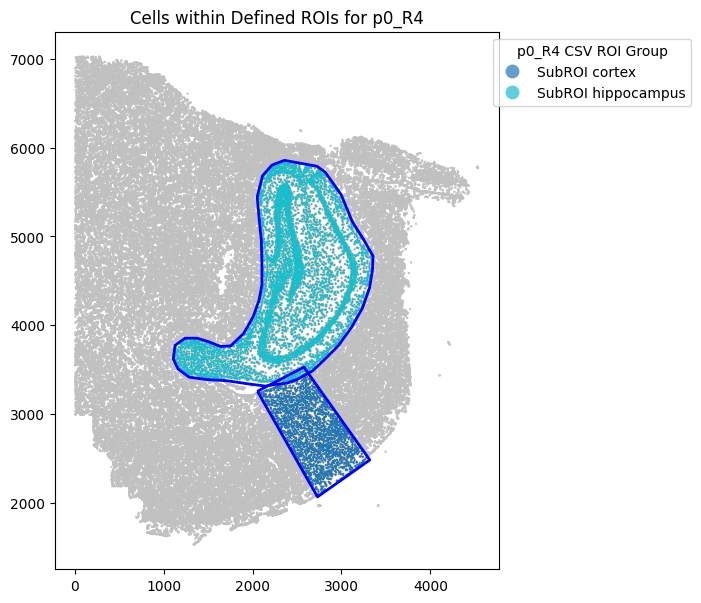

In [17]:
if PLOT_INTERMEDIATE_ROI_VISUALIZATIONS:
    processor_s1.step_9_plot_roi_visualization()

In [18]:
adata_s1 = processor_s1.adata_filtered_rois


--- Initializing SampleProcessor for sample: p30_R3 ---
Step 1: Loading RAW AnnData for p30_R3 from DATA/p30-E165/R3/cell_by_gene.csv


Initial adata shape from CSV: (44048, 1000)
Step 2: Filtering 'Blank' genes for p30_R3
Filtered out 'Blank' genes. Kept 960 out of 1000 genes. New shape: (44048, 960)
Step 3: Filtering cells by min expression (25) for p30_R3
Filtered cells by min expression. Kept 42520 out of 44048 cells. New shape: (42520, 960)
Step 3.5: Normalizing and log-transforming data for p30_R3...
Data for p30_R3 was loaded from raw counts. Applying sc.pp.normalize_total and sc.pp.log1p.
Per-sample normalization and log-transformation complete.
Step 4: Loading cell boundaries for p30_R3 from DATA/p30-E165/R3/cell_boundaries.parquet
Loaded cell boundaries. Shape: (308336, 9)
Step 5: Loading ROI geometry for p30_R3 from DATA/p30-E165/R3/p30_R3_ROI_28-05-25_16-57_geometry.csv
Loaded and converted ROI geometries. Shape: (2, 4)
Step 6: Spatially selecting cells within ROIs for p30_R3
Found 43911 cells within any defined ROIs.
Step 7: Assigning sample-specific ROI labels for p30_R3
Mapping CSV group 'SubROI cortex' 

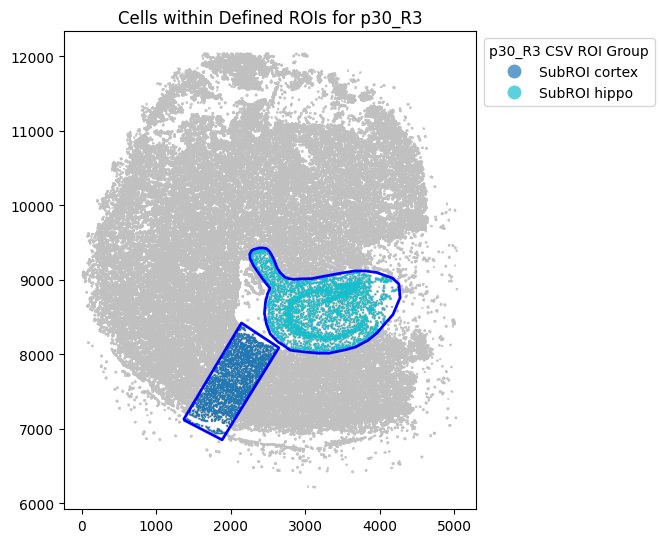

In [19]:
processor_s2 = SampleProcessor(
    base_path=base_path_s2,
    h5ad_filename=h5ad_filename_s2,
    cell_boundaries_filename=cell_boundaries_filename_common,
    roi_csv_filename=roi_csv_filename_s2,
    sample_prefix=sample_prefix_s2,
    target_roi_labels=target_roi_names,
    use_raw_counts=True,  # Set to True to load from 'cell_by_gene.csv' for this sample
    raw_counts_csv_filename="cell_by_gene.csv" # Assumed name if use_raw_counts is True
)
# Note: If running steps individually, ensure adata_s2 is assigned appropriately.
# For a full run:
adata_s2 = processor_s2.run_all_steps()

## 3. Combine AnnData Objects

In [20]:
print(f"adata_s1 shape before concat: {adata_s1.shape}, obs keys: {adata_s1.obs.columns.tolist()}")
print(f"adata_s1 roi_assignment example: {adata_s1.obs['roi_assignment'].unique()[:5]}")
print(f"adata_s2 shape before concat: {adata_s2.shape}, obs keys: {adata_s2.obs.columns.tolist()}")
print(f"adata_s2 roi_assignment example: {adata_s2.obs['roi_assignment'].unique()[:5]}")

adata_s1 shape before concat: (9934, 960), obs keys: ['roi_assignment']
adata_s1 roi_assignment example: ['p0_R4_ROI1' 'p0_R4_ROI2']
adata_s2 shape before concat: (6172, 960), obs keys: ['roi_assignment']
adata_s2 roi_assignment example: ['p30_R3_ROI1' 'p30_R3_ROI2']


In [21]:
# Ensure var_names (genes) are identical or handle appropriately (e.g., intersection)
# For now, assuming 'join="inner"' handles gene differences by taking intersection.
adata_combined = ad.concat(
    {"s1": adata_s1, "s2": adata_s2},
    label="sample_batch_id",  # Adds 's1' or 's2' to obs
    join="inner",        # Keeps only common genes
    index_unique="-"     # Appends batch key to make cell indices unique if needed
)
print(f"Combined AnnData shape: {adata_combined.shape}")
print(f"Combined AnnData .obs columns: {adata_combined.obs.columns}")
print(f"Value counts for 'roi_assignment' in combined data:\n{adata_combined.obs['roi_assignment'].value_counts()}")
print(f"Value counts for 'sample_batch_id' in combined data:\n{adata_combined.obs['sample_batch_id'].value_counts()}")

Combined AnnData shape: (16106, 960)
Combined AnnData .obs columns: Index(['roi_assignment', 'sample_batch_id'], dtype='object')
Value counts for 'roi_assignment' in combined data:
roi_assignment
p0_R4_ROI2     7711
p30_R3_ROI2    4024
p0_R4_ROI1     2223
p30_R3_ROI1    2148
Name: count, dtype: int64
Value counts for 'sample_batch_id' in combined data:
sample_batch_id
s1    9934
s2    6172
Name: count, dtype: int64


In [22]:
# 3.1 Create a generic ROI type for ComBat covariate to avoid perfect confounding
if adata_combined is not None:
    adata_combined.obs['generic_roi_type'] = adata_combined.obs['roi_assignment'].apply(
        lambda x: x.split('_')[-1] if isinstance(x, str) else 'Unknown'
    )
    print(f"Created 'generic_roi_type' for ComBat covariates:\n{adata_combined.obs['generic_roi_type'].value_counts()}")
    if not isinstance(adata_combined.obs['generic_roi_type'].dtype, pd.CategoricalDtype):
        adata_combined.obs['generic_roi_type'] = adata_combined.obs['generic_roi_type'].astype('category')

Created 'generic_roi_type' for ComBat covariates:
generic_roi_type
ROI2    11735
ROI1     4371
Name: count, dtype: int64


In [23]:
# 3.2 Filter low-variance genes before ComBat
if adata_combined is not None:
    print(f"Shape before filtering low-variance genes: {adata_combined.shape}")
    # More stringent gene filtering
    print("Applying gene filtering: min_counts=5, then min_cells=20")
    sc.pp.filter_genes(adata_combined, min_counts=5)
    sc.pp.filter_genes(adata_combined, min_cells=20)
    print(f"Shape after filtering low-variance genes: {adata_combined.shape}")

# 3.5 Batch Correction using ComBat
# Note: This requires the 'pycombat' package or similar to be installed (e.g., pip install pycombat)
# ComBat expects log-transformed data. Our per-sample processing should ensure this.
if adata_combined is not None and 'sample_batch_id' in adata_combined.obs and 'generic_roi_type' in adata_combined.obs:
    print("\nApplying ComBat for batch correction across 'sample_batch_id' preserving 'generic_roi_type'...")
    try:
        # Ensure 'sample_batch_id' is categorical for ComBat
        if not isinstance(adata_combined.obs['sample_batch_id'].dtype, pd.CategoricalDtype):
            adata_combined.obs['sample_batch_id'] = adata_combined.obs['sample_batch_id'].astype('category')
        
        # Ensure 'generic_roi_type' (covariate) is categorical
        if not isinstance(adata_combined.obs['generic_roi_type'].dtype, pd.CategoricalDtype):
                adata_combined.obs['generic_roi_type'] = adata_combined.obs['generic_roi_type'].astype('category')

        print("Attempting batch correction using sc.pp.combat...")
        sc.pp.combat(adata_combined, key='sample_batch_id', covariates=['generic_roi_type']) # inplace=True by default
        print("Scanpy ComBat batch correction (sc.pp.combat) with 'generic_roi_type' as covariate complete. adata_combined.X has been updated.")

        # After ComBat, check for non-positive values and shift if necessary
        if adata_combined.X is not None:
            min_val = adata_combined.X.min()
            if min_val <= 0:
                print(f"ComBat output contains non-positive values (min: {min_val}). Shifting data to be strictly positive.")
                # Convert to dense if sparse, perform operation, then potentially convert back if memory is an issue
                # For now, assume direct operation is fine.
                if hasattr(adata_combined.X, "toarray"): # Check if sparse
                    adata_combined.X = adata_combined.X.toarray() - min_val + 0.0001
                else:
                    adata_combined.X = adata_combined.X - min_val + 0.0001
                print(f"Data shifted. New min value: {adata_combined.X.min()}")
    except AttributeError as attr_err:
        print(f"AttributeError during sc.pp.combat: {attr_err}")
        print("This might mean 'sc.pp.combat' is not available in your Scanpy version, or an underlying issue.")
        print("Ensure your Scanpy version is recent and try installing 'pycombat' and 'patsy': 'pip install pycombat patsy'.")
        print("Proceeding with DGE on non-batch-corrected combined data.")
        
    except ImportError as imp_err: # Catches import errors for dependencies of sc.pp.combat (like pycombat or patsy)
        print(f"ImportError during ComBat setup or execution: {imp_err}")
        print("This often means a required package (like 'pycombat' or 'patsy') for sc.pp.combat is missing.")
        print("Please try installing them: 'pip install pycombat patsy'.")
        print("Proceeding with DGE on non-batch-corrected combined data.")
        
    except Exception as e_combat: # Catch any other unexpected errors from sc.pp.combat
        print(f"An unexpected error occurred during sc.pp.combat: {e_combat}")
        print("Proceeding with DGE on non-batch-corrected combined data.")
else:
    print("Skipping ComBat batch correction as combined data is not available or 'sample_batch_id' is missing.")

Shape before filtering low-variance genes: (16106, 960)
Applying gene filtering: min_counts=5, then min_cells=20
Shape after filtering low-variance genes: (16106, 960)

Applying ComBat for batch correction across 'sample_batch_id' preserving 'generic_roi_type'...
Attempting batch correction using sc.pp.combat...


Scanpy ComBat batch correction (sc.pp.combat) with 'generic_roi_type' as covariate complete. adata_combined.X has been updated.
ComBat output contains non-positive values (min: -14.57086223876796). Shifting data to be strictly positive.
Data shifted. New min value: 0.0001


## 4. Differential Gene Expression (DGE) Analysis

In [24]:
def perform_dge_and_visualize(adata_input, group_to_test, reference_group, pval_thresh, logfc_thresh, top_n_genes, plot_flag=True):
    """
    Performs DGE analysis between two groups in an AnnData object and visualizes results.
    """
    if adata_input is None or adata_input.shape[0] < 2 or adata_input.shape[1] == 0: # Min 1 cell per group
        print(f"Skipping DGE for {group_to_test} vs {reference_group} due to insufficient data.")
        return None

    print(f"\n--- DGE: {group_to_test} (test) vs {reference_group} (reference) ---")
    
    # Filter for the two specific groups for this comparison
    adata_for_dge = adata_input[adata_input.obs['roi_assignment'].isin([group_to_test, reference_group])].copy()
    
    if adata_for_dge.obs.groupby('roi_assignment').size().min() < 1: # Check if any group is empty
         print(f"Warning: One of the groups ('{group_to_test}' or '{reference_group}') is empty or has too few cells after filtering for DGE. Skipping.")
         return None
    if len(adata_for_dge.obs['roi_assignment'].unique()) < 2:
        print(f"Warning: Only one group present after filtering for DGE ('{group_to_test}', '{reference_group}'). Skipping comparison.")
        return None


    print(f"Shape of AnnData for this DGE comparison: {adata_for_dge.shape}")
    print(f"Cell counts per group for DGE:\n{adata_for_dge.obs['roi_assignment'].value_counts()}")

    # Data should already be log-transformed from load_sample_data.
    # sc.pp.log1p(adata_for_dge) # REMOVED

    # Perform DGE
    dge_key = f"rank_genes_{group_to_test}_vs_{reference_group}"
    sc.tl.rank_genes_groups(
        adata_for_dge,
        groupby='roi_assignment',
        groups=[group_to_test],      # Group to test (numerator for logFC)
        reference=reference_group,   # Reference group (denominator for logFC)
        method='wilcoxon',
        corr_method='benjamini-hochberg',
        key_added=dge_key,
        use_raw=False # Ensure we use the .X layer (ComBat corrected)
    )
    print("DGE calculation complete.")

    # Visualize DGE results (Volcano Plot)
    if plot_flag:
        print(f"Creating volcano plot for {group_to_test} vs {reference_group}...")
        fig, ax = create_volcano_plot(
            adata_for_dge,
            group_name=group_to_test, # This is the group for which scores, pvals etc. are reported directly
            key=dge_key,
            pval_threshold=pval_thresh,
            logfc_threshold=logfc_thresh,
            title=f"Volcano: {group_to_test} vs {reference_group}",
            show_gene_labels=True,
            top_genes=top_n_genes
        )
        plt.show()

    # Display DGE results as a DataFrame
    try:
        # The results are structured under the name of the group tested (group_to_test)
        dge_results_df = pd.DataFrame(adata_for_dge.uns[dge_key]['names'])[group_to_test]
        dge_scores_df = pd.DataFrame(adata_for_dge.uns[dge_key]['scores'])[group_to_test]
        dge_pvals_df = pd.DataFrame(adata_for_dge.uns[dge_key]['pvals_adj'])[group_to_test]
        dge_logfc_df = pd.DataFrame(adata_for_dge.uns[dge_key]['logfoldchanges'])[group_to_test]

        summary_df = pd.DataFrame({
            'gene': dge_results_df,
            'score': dge_scores_df,
            'pval_adj': dge_pvals_df,
            'log2fc': dge_logfc_df
        })
        print(f"\nTop DEGs for {group_to_test} compared to {reference_group} (log2fc > 0 means higher in {group_to_test}):")
        print(summary_df.head(top_n_genes * 2)) # Show more for inspection
        return summary_df
    except KeyError as e:
        print(f"Error extracting DGE results for {group_to_test}: {e}")
        print(f"Available keys in adata_for_dge.uns['{dge_key}']: {list(adata_for_dge.uns[dge_key].keys())}")
        if 'names' in adata_for_dge.uns[dge_key]:
             print(f"Structure of 'names': {type(adata_for_dge.uns[dge_key]['names'])}")
             if isinstance(adata_for_dge.uns[dge_key]['names'], np.recarray):
                  print(f"Field names in 'names' recarray: {adata_for_dge.uns[dge_key]['names'].dtype.names}")
        return None

### 4.1 DGE: ROI1 (Sample 2 vs Sample 1)

Performing DGE for ROI1: p30_R3_ROI1 (test) vs p0_R4_ROI1 (reference)

--- DGE: p30_R3_ROI1 (test) vs p0_R4_ROI1 (reference) ---
Shape of AnnData for this DGE comparison: (4371, 960)
Cell counts per group for DGE:
roi_assignment
p0_R4_ROI1     2223
p30_R3_ROI1    2148
Name: count, dtype: int64
DGE calculation complete.
Creating volcano plot for p30_R3_ROI1 vs p0_R4_ROI1...
Volcano plot summary for p30_R3_ROI1:
Total genes: 960
Significant genes: 34 (3.5%)
Upregulated: 14
Downregulated: 20


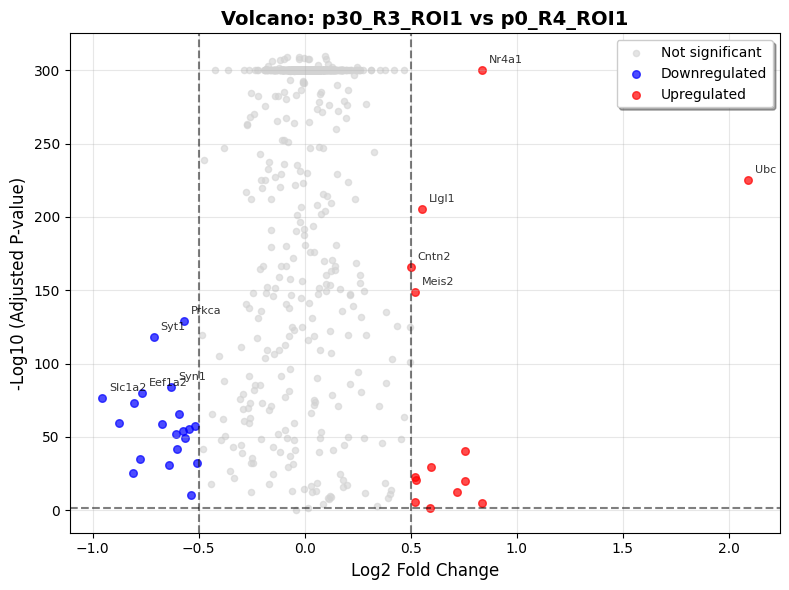


Top DEGs for p30_R3_ROI1 compared to p0_R4_ROI1 (log2fc > 0 means higher in p30_R3_ROI1):
       gene      score  pval_adj    log2fc
0       Dsp  57.038101       0.0  0.219447
1    Slc1a7  56.880535       0.0  0.073833
2      Prlr  56.834957       0.0  0.120273
3      Gnb5  56.829037       0.0  0.096809
4     Efna4  56.777538       0.0  0.056994
5      Chat  56.726040       0.0  0.021122
6   Pla2g4d  56.726040       0.0  0.092119
7      Cd28  56.726040       0.0  0.042563
8       En1  56.674538       0.0  0.091137
9    Gabrr1  56.623039       0.0  0.167974
10    Alg13  56.623039       0.0  0.111833
11   Sema3f  56.520042       0.0  0.071639
12   Sema3a  56.314072       0.0  0.048021
13     Ntn3  56.262547       0.0  0.140194
14     Pax2  56.159550       0.0  0.142702
15     Lhx1  56.056553       0.0  0.254000
16     Cd40  56.005054       0.0  0.074177
17    Cplx3  55.953674       0.0  0.062592
18    Lrig2  55.101067       0.0 -0.009599
19   Tuba3a  54.099594       0.0  0.466959


In [25]:
if adata_combined is not None:
    roi1_s1_label = f"{sample_prefix_s1}_{target_roi_names[0]}" # e.g., p0_R4_ROI1
    roi1_s2_label = f"{sample_prefix_s2}_{target_roi_names[0]}" # e.g., p30_R3_ROI1

    # Check if both ROI1 labels exist in the combined data
    if roi1_s1_label in adata_combined.obs['roi_assignment'].unique() and \
       roi1_s2_label in adata_combined.obs['roi_assignment'].unique():
        
        print(f"Performing DGE for ROI1: {roi1_s2_label} (test) vs {roi1_s1_label} (reference)")
        summary_roi1 = perform_dge_and_visualize(
            adata_input=adata_combined,
            group_to_test=roi1_s2_label,    # Test group
            reference_group=roi1_s1_label,  # Reference group
            pval_thresh=pval_threshold,
            logfc_thresh=logfc_threshold,
            top_n_genes=top_genes_to_show,
            plot_flag=PLOT_FINAL_DGE_VOLCANO
        )
    else:
        print(f"Skipping DGE for ROI1 as one or both required ROI groups ({roi1_s1_label}, {roi1_s2_label}) are not present in the combined data.")
        print(f"Available ROI assignments: {adata_combined.obs['roi_assignment'].unique()}")

### 4.2 DGE: ROI2 (Sample 2 vs Sample 1)

Performing DGE for ROI2: p30_R3_ROI2 (test) vs p0_R4_ROI2 (reference)

--- DGE: p30_R3_ROI2 (test) vs p0_R4_ROI2 (reference) ---
Shape of AnnData for this DGE comparison: (11735, 960)
Cell counts per group for DGE:
roi_assignment
p0_R4_ROI2     7711
p30_R3_ROI2    4024
Name: count, dtype: int64
DGE calculation complete.
Creating volcano plot for p30_R3_ROI2 vs p0_R4_ROI2...
Volcano plot summary for p30_R3_ROI2:
Total genes: 960
Significant genes: 11 (1.1%)
Upregulated: 11
Downregulated: 0


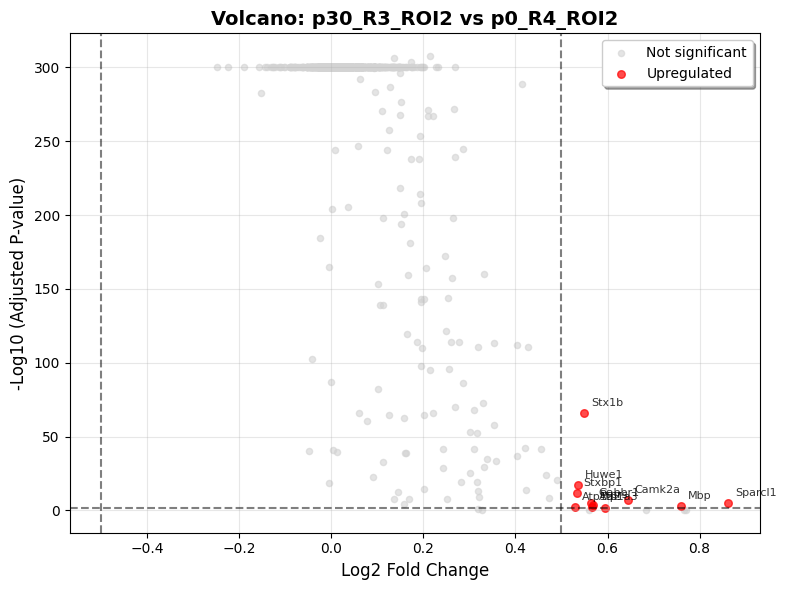


Top DEGs for p30_R3_ROI2 compared to p0_R4_ROI2 (log2fc > 0 means higher in p30_R3_ROI2):
       gene      score  pval_adj    log2fc
0     Unc5d  86.939529       0.0  0.037094
1      Lnpk  86.373199       0.0  0.030895
2     Lrig2  86.014992       0.0  0.005795
3     Camk4  85.811058       0.0  0.062244
4      Prlr  85.776207       0.0 -0.053090
5     Mef2c  85.649544       0.0  0.090540
6    Homer1  85.556747       0.0  0.078871
7      Stx8  84.418770       0.0  0.035384
8     Cdc42  83.846062       0.0  0.007169
9     Calb1  83.813171       0.0  0.054187
10  Nectin3  82.639824       0.0  0.050349
11    Hspd1  82.435516       0.0  0.028440
12    Mapk8  80.990456       0.0  0.067156
13    Kcnh7  80.435265       0.0  0.027202
14      Ntm  80.185722       0.0  0.123196
15   Bmerb1  80.071510       0.0  0.092775
16    Fubp1  78.662598       0.0  0.023141
17    Negr1  74.485870       0.0  0.173475
18     Pak1  66.683060       0.0  0.067796
19   Lrrc4c  66.470642       0.0  0.110485


In [26]:
if adata_combined is not None and len(target_roi_names) >= 2:
    roi2_s1_label = f"{sample_prefix_s1}_{target_roi_names[1]}" # e.g., p0_R4_ROI2
    roi2_s2_label = f"{sample_prefix_s2}_{target_roi_names[1]}" # e.g., p30_R3_ROI2

    # Check if both ROI2 labels exist
    if roi2_s1_label in adata_combined.obs['roi_assignment'].unique() and \
       roi2_s2_label in adata_combined.obs['roi_assignment'].unique():

        print(f"Performing DGE for ROI2: {roi2_s2_label} (test) vs {roi2_s1_label} (reference)")
        summary_roi2 = perform_dge_and_visualize(
            adata_input=adata_combined,
            group_to_test=roi2_s2_label,    # Test group
            reference_group=roi2_s1_label,  # Reference group
            pval_thresh=pval_threshold,
            logfc_thresh=logfc_threshold,
            top_n_genes=top_genes_to_show,
            plot_flag=PLOT_FINAL_DGE_VOLCANO
        )
    else:
        print(f"Skipping DGE for ROI2 as one or both required ROI groups ({roi2_s1_label}, {roi2_s2_label}) are not present in the combined data.")
        print(f"Available ROI assignments: {adata_combined.obs['roi_assignment'].unique()}")
elif adata_combined is not None:
    print("Skipping DGE for ROI2 as only one target ROI name was specified.")

In [27]:
print("\n--- End of Combined DEG Analysis Script ---")


--- End of Combined DEG Analysis Script ---
